#Step 4: Extract Embeddings(sample embedding)
The embedding used here is the encoded representation of the input image obtained from the encoder part of the autoencoder model.

sample_embedding is obtained by passing a sample input (cropped_objects[:1]) through the encoder. It outputs a compressed representation (embedding) of the input image.

In [ ]:
encoder = keras.Model(input_img, encoded)

# Example of extracting embeddings
sample_embedding = encoder.predict(cropped_objects[:1])
print("Embedding shape:", sample_embedding.shape)

print("Embedding size:", sample_embedding.size)

1/1 [==============================] - 0s 244ms/step
Embedding shape: (1, 8, 8, 8)
Embedding size: 512


#Indexing the embeddings (20 points)
Use docker compose to bring up two docker containers, your application container with the dev environment (you must have done this in Step 1) and a second container with postgres.

docker pull postgres:latest

Process all the detected object sub-images for each frame of each video to compile your final results in the following tabular structure: [vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info, vector, optional]

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension) you can use this guide.

Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.

#Process the detected object sub-images including the vectors (embeddings) for each detected object in the structure:

Extract sub-images for each detected object.
Use the autoencoder to generate embeddings for each sub-image.
Append these embeddings to my results.

In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
from datetime import timedelta
import logging
from keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Define autoencoder model
input_img = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
adam_optimizer = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=adam_optimizer, loss='binary_crossentropy')
encoder = Model(input_img, encoded)

# Function to extract and preprocess sub-images
def preprocess_sub_image(frame, bbox, size=(64, 64)):
    xmin, ymin, xmax, ymax = map(int, bbox)
    sub_img = frame[ymin:ymax, xmin:xmax]
    sub_img = cv2.resize(sub_img, size)
    sub_img = sub_img.astype(np.float32) / 255.0
    return sub_img

# Process each video and extract embeddings
video_paths = [
    "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
    "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
    "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
]

results = []

for vidId, video_path in enumerate(video_paths):
    logging.info(f"Processing video {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error(f"Error: Could not open video {video_path}")
        continue

    frame_num = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    logging.info(f"Total frames: {total_frames}, FPS: {fps}")

    frame_interval = 10  # Process every 10th frame

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % frame_interval == 0:
            logging.info(f"Processing frame {frame_num}/{total_frames}")
            timestamp = str(timedelta(seconds=frame_num / fps))

            results_yolo = model(frame)
            detections = results_yolo.pandas().xyxy[0]

            for _, detection in detections.iterrows():
                detectedObjId = detection['class']
                detectedObjClass = detection['name']
                confidence = detection['confidence']
                bbox_info = [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']]

                sub_image = preprocess_sub_image(frame, bbox_info)
                sub_image = np.expand_dims(sub_image, axis=0)
                embedding = encoder.predict(sub_image).flatten()

                results.append([
                    vidId, frame_num, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, embedding.tolist()
                ])

                # Print embedding shape and size
                print(f"Embedding shape: {embedding.shape}")
                print(f"Embedding size: {embedding.size}")

        frame_num += 1

    cap.release()
    logging.info(f"Finished processing video {video_path}")

# Save results to CSV
df = pd.DataFrame(results, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox_info', 'vector'])
df.to_csv('detection_results_with_embeddings.csv', index=False)
logging.info("Detection results with embeddings saved to detection_results_with_embeddings.csv")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-21 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Streaming output truncated to the last 5000 lines.
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 20ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 21ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 23ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 21ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s 22ms/step
Embedding shape: (512,)
Embedding size: 512
1/1 [==============================] - 0s

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('detection_results_with_embeddings.csv')

# Print the head of the DataFrame
print(df.head())

   vidId  frameNum       timestamp  detectedObjId detectedObjClass  \
0      0       120  0:00:05.005000              0           person   
1      0       120  0:00:05.005000              0           person   
2      0       120  0:00:05.005000              0           person   
3      0       120  0:00:05.005000              0           person   
4      0       120  0:00:05.005000              0           person   

   confidence                                          bbox_info  \
0    0.865962  [1.8373260498046875, 215.29153442382812, 165.1...   
1    0.846955  [234.6238555908203, 265.1407470703125, 293.524...   
2    0.819844  [345.802490234375, 272.62176513671875, 424.704...   
3    0.766788  [408.46807861328125, 192.9556121826172, 618.45...   
4    0.744017  [417.0980224609375, 255.2174072265625, 464.637...   

                                              vector  
0  [0.0878366008400917, 0.045856595039367676, 0.0...  
1  [0.03064996562898159, 0.015085775405168533, 0....  
2  [0

#Result Analysis
**The output Embedding shape: (512,)** indicates that each embedding is a 1-dimensional array (vector) with 512 elements. **The size of the embedding, which is also 512**, corresponds to the total number of elements in the array.

This means that for each detected object in the videos, **the autoencoder produces an embedding that is represented as a vector with 512 values, capturing the encoded representation of the corresponding sub-image of the detected object.**

df will include all the detection results along with embeddings for each detected object in the videos. Each row in df represents one detection instance (one object detected in one frame of one video), with the corresponding embedding vector included.

#postgresql with pgvector extension

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension)

In [ ]:
!apt update
!apt install postgresql postgresql-contrib
!pip install psycopg2-binary


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [929 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,922 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,093 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,474 kB

In [ ]:
!service postgresql start
!sudo -u postgres psql -c "CREATE DATABASE mydatabase;"


 * Starting PostgreSQL 14 database server
   ...done.
CREATE DATABASE


In [ ]:
# Install required packages for compiling pgvector
!apt-get -qq install build-essential postgresql-server-dev-all
!git clone https://github.com/ankane/pgvector.git
%cd pgvector
!make
!make install

Selecting previously unselected package python3-yaml.
(Reading database ... 123888 files and directories currently installed.)
Preparing to unpack .../00-python3-yaml_5.4.1-1ubuntu1_amd64.deb ...
Unpacking python3-yaml (5.4.1-1ubuntu1) ...
Selecting previously unselected package binfmt-support.
Preparing to unpack .../01-binfmt-support_2.2.1-2_amd64.deb ...
Unpacking binfmt-support (2.2.1-2) ...
Selecting previously unselected package llvm-14-runtime.
Preparing to unpack .../02-llvm-14-runtime_1%3a14.0.0-1ubuntu1.1_amd64.deb ...
Unpacking llvm-14-runtime (1:14.0.0-1ubuntu1.1) ...
Selecting previously unselected package libpfm4:amd64.
Preparing to unpack .../03-libpfm4_4.11.1+git32-gd0b85fb-1ubuntu0.1_amd64.deb ...
Unpacking libpfm4:amd64 (4.11.1+git32-gd0b85fb-1ubuntu0.1) ...
Selecting previously unselected package llvm-14.
Preparing to unpack .../04-llvm-14_1%3a14.0.0-1ubuntu1.1_amd64.deb ...
Unpacking llvm-14 (1:14.0.0-1ubuntu1.1) ...
Selecting previously unselected package libffi-de

In [ ]:
import pgvector
print("pgvector imported successfully!")

pgvector imported successfully!


In [ ]:
%cd pgvector
!ls

[Errno 2] No such file or directory: 'pgvector'
/content/pgvector
CHANGELOG.md  LICENSE	Makefile.win  README.md  src   vector.control
Dockerfile    Makefile	META.json     sql	 test  vector.so


In [ ]:
!sudo -u postgres psql -c "ALTER USER postgres WITH PASSWORD 'postgres';"


ALTER ROLE


In [ ]:
# Create a new role 'root' with superuser privileges
!sudo -u postgres psql -U postgres -c "CREATE ROLE root WITH SUPERUSER;"

CREATE ROLE


In [ ]:
import psycopg2
import os

# Replace placeholders with your actual connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
# Retrieve password from environment variable
password = "postgres"

try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Proceed with your database operations...

    # Close connection
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Successfully connected to PostgreSQL!


#index video images' embedding vectors in a PostgreSQL database using the pgvector extension

In [ ]:
import psycopg2

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    cur = conn.cursor()

    # Create the pgvector extension
    cur.execute("CREATE EXTENSION IF NOT EXISTS vector;")
    conn.commit()
    print("pgvector extension created successfully!")

    # Create table with pgvector extension
    cur.execute("""
    CREATE TABLE IF NOT EXISTS video_embeddings (
        vidId INT,
        frameNum INT,
        timestamp TEXT,
        detectedObjId INT,
        detectedObjClass TEXT,
        confidence FLOAT,
        bbox_info TEXT,
        vector vector(512)  -- Assuming embedding size of 512
    );
    """)

    conn.commit()
    print("Table created successfully!")

    cur.close()
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Successfully connected to PostgreSQL!
pgvector extension created successfully!
Table created successfully!


In [ ]:
import psycopg2
import pandas as pd
import ast

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    cur = conn.cursor()

    # Load CSV data from the correct path in Google Colab
    csv_file_path = '/content/detection_results_with_embeddings.csv'
    df = pd.read_csv(csv_file_path)

    # Insert data into the table
    for _, row in df.iterrows():
        vector = ast.literal_eval(row['vector'])  # Convert string to list
        cur.execute("""
        INSERT INTO video_embeddings (vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
        """, (row['vidId'], row['frameNum'], row['timestamp'], row['detectedObjId'], row['detectedObjClass'], row['confidence'], row['bbox_info'], vector))

    conn.commit()
    print("Data inserted successfully!")

    cur.close()
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Successfully connected to PostgreSQL!
Data inserted successfully!


In [ ]:
import psycopg2
from psycopg2.extras import DictCursor

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Create a cursor to execute SQL queries
    with conn.cursor(cursor_factory=DictCursor) as cur:
        # Your indexing SQL command here
        index_query = """
        CREATE INDEX video_embeddings_vector_idx ON video_embeddings USING ivfflat(vector);
        """
        cur.execute(index_query)
        print("Indexing complete.")

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


Successfully connected to PostgreSQL!
Indexing complete.
Connection closed.


# Visualization of insertyed table

In [ ]:
import psycopg2
from tabulate import tabulate  # This is optional, for pretty printing

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Create a cursor object using the connection
    cur = conn.cursor()

    # Query to fetch first 10 rows from video_embeddings table
    cur.execute("SELECT * FROM video_embeddings LIMIT 10;")

    # Fetch all rows
    rows = cur.fetchall()

    # Print the rows using tabulate for better formatting (optional)
    headers = [desc[0] for desc in cur.description]
    print(tabulate(rows, headers=headers, tablefmt="psql"))

    # Close cursor and connection
    cur.close()
    conn.close()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


Successfully connected to PostgreSQL!
+---------+------------+----------------+-----------------+--------------------+--------------+---------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.**

In [ ]:
import psycopg2
from psycopg2.extras import DictCursor

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"


# Connect to the database
try:
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Query to fetch vectors and metadata for exploration
    query = """
    SELECT vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector
    FROM video_embeddings
    LIMIT 10;  -- Adjust to fetch more or fewer records for exploration
    """

    with conn.cursor(cursor_factory=DictCursor) as cur:
        cur.execute(query)
        rows = cur.fetchall()

        for row in rows:
            # Use direct column names or specify aliases as per your actual column names
            vidId = row['vidid']  # Ensure 'vidid' matches the actual column name from PostgreSQL
            frameNum = row['framenum']
            timestamp = row['timestamp']
            detectedObjId = row['detectedobjid']
            detectedObjClass = row['detectedobjclass']
            confidence = row['confidence']
            bbox_info = row['bbox_info']
            vector = row['vector']

            # Print or analyze metadata and vector structure
            print(f"vidId: {vidId}, frameNum: {frameNum}, timestamp: {timestamp}")
            print(f"Detected Object: ID={detectedObjId}, Class={detectedObjClass}, Confidence={confidence}")
            print(f"Bbox Info: {bbox_info}")
            print(f"Vector: {vector}")
            print(f"Vector Length: {len(vector)}")  # Check vector length

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


Successfully connected to PostgreSQL!
vidId: 0, frameNum: 120, timestamp: 0:00:05.005000
Detected Object: ID=0, Class=person, Confidence=0.8659622073173523
Bbox Info: [1.8373260498046875, 215.29153442382812, 165.15162658691406, 358.5021057128906]
Vector: [0.0878366,0.045856595,0,0,0,0.3918819,0.2776747,0.499821,0.09860694,0.010151115,0,0,0,0.43404964,0.23113386,0.49666873,0.10467694,0.020589944,0,0,0,0.43484834,0.23463213,0.5152214,0.10658407,0.056030206,0,0,0,0.46012214,0.23863141,0.5259346,0.12443555,0.05876322,0,0,0,0.40387586,0.20476283,0.47177818,0.07684957,0.064527065,0,0,0,0.3119873,0.1595476,0.40951508,0.07562601,0.048258685,0,0,0,0.30002838,0.13794827,0.33871925,0.10491022,0.015105193,0,0,0,0.26858616,0.0876772,0.2818524,0.05897206,0,0,0,0,0.4218433,0.11243284,0.480255,0.02932216,0,0,0,0,0.45695874,0.05876904,0.4998692,0.06919917,0,0,0,0,0.4721097,0.086389296,0.51297224,0.06495599,0,0,0,0,0.493198,0.087992124,0.5415064,0.056044627,0,0,0,0,0.44277886,0.062441435,0.536,0.0176350

#without duplication of similar images

Successfully connected to PostgreSQL!
Loading frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 130 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 130 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 140 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 140 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 150 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 150 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 160 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4


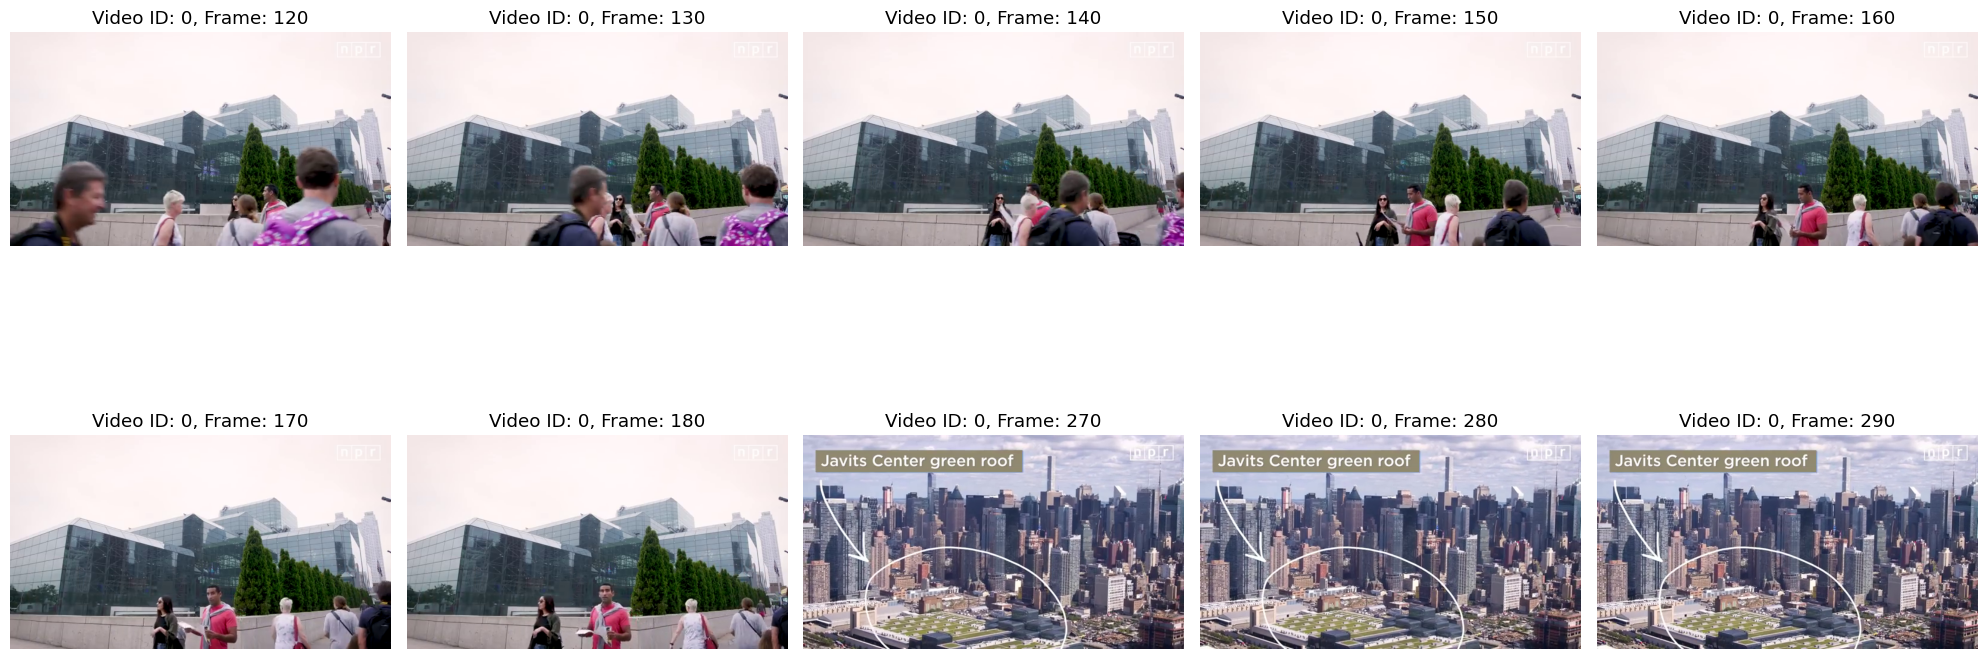

Connection closed.


In [ ]:
import pandas as pd
import ast
import psycopg2
import matplotlib.pyplot as plt
import cv2

# Function to load a specific frame from a video file
def load_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        print(f"Failed to load frame {frame_num} from {video_path}")
        return None

# Load the CSV file containing the embeddings
df = pd.read_csv('/content/detection_results_with_embeddings.csv')

# Select a query vector (example: first row)
query_vector = df.iloc[0]['vector']

# Convert the string representation of the list to an actual list
query_vector = ast.literal_eval(query_vector)

# Convert the list of floats to a PostgreSQL array string with brackets
query_vector_str = '[' + ','.join(map(str, query_vector)) + ']'

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Construct the search query with DISTINCT ON clause
search_query = f"""
SELECT DISTINCT ON (vidId, frameNum) vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector,
       vector <-> '{query_vector_str}'::vector AS distance
FROM video_embeddings
ORDER BY vidId, frameNum, distance ASC
LIMIT 10;
"""

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Execute the search query
    with conn.cursor() as cur:
        cur.execute(search_query)
        rows = cur.fetchall()

        # Convert result to DataFrame for better visualization (optional)
        columns = ['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass',
                   'confidence', 'bbox_info', 'vector', 'distance']
        df_results = pd.DataFrame(rows, columns=columns)

        # Display the first 10 similar images
        video_paths = [
            "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
            "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
            "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
        ]

        plt.figure(figsize=(20, 10))
        for i, row in df_results.iterrows():
            if i >= 10:  # Display only the first 10 similar images
                break

            vidId = row['vidId']
            frameNum = row['frameNum']
            video_path = video_paths[vidId]

            print(f"Loading frame {frameNum} from video {video_path}")
            frame = load_frame(video_path, frameNum)

            if frame is not None:
                print(f"Frame {frameNum} from video {video_path} loaded successfully with shape: {frame.shape}")
                plt.subplot(2, 5, i+1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"Video ID: {vidId}, Frame: {frameNum}")
                plt.axis('off')
            else:
                print(f"Failed to display frame {frameNum} from video {video_path}")

        plt.tight_layout()
        plt.show()

except psycopg2.Error as e:
    print(f"Error executing query: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


#order by Distance

Successfully connected to PostgreSQL!
Loading frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 2300 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
Frame 2300 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4 loaded successfully with shape: (360, 480, 3)
Loading frame 2310 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
Frame 2310 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4 loaded successfully with shape: (360, 480, 3)
Loading frame 860 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 860 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 2320 from vi

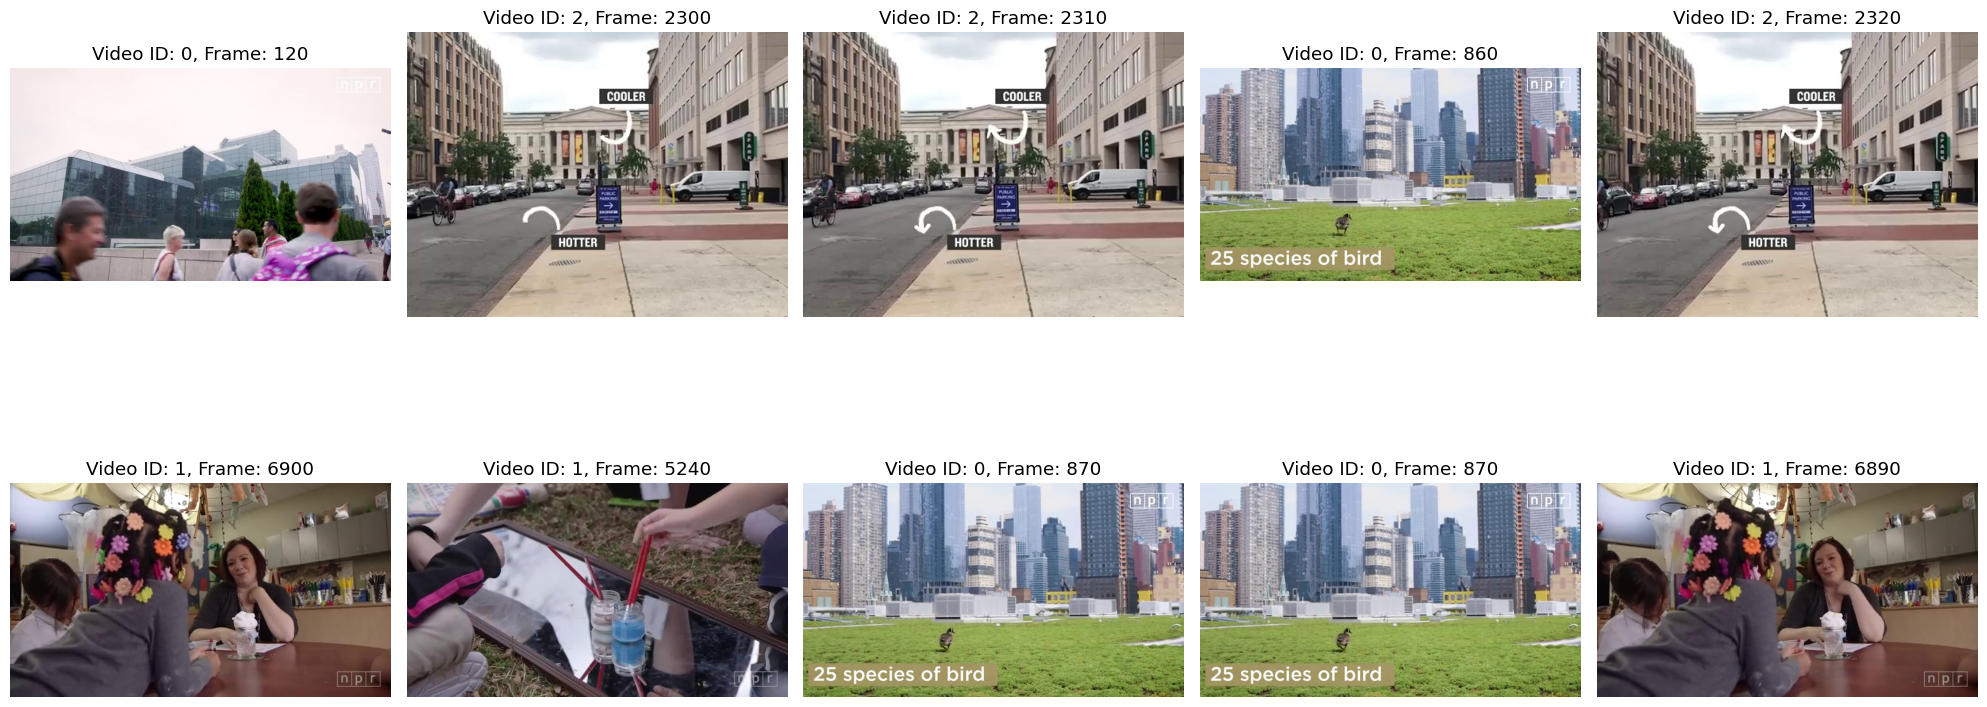

Connection closed.


In [ ]:
import psycopg2
import pandas as pd
import ast
import matplotlib.pyplot as plt
import cv2

# Function to load a specific frame from a video file
def load_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        print(f"Failed to load frame {frame_num} from {video_path}")
        return None

# Load the CSV file containing the embeddings
df = pd.read_csv('/content/detection_results_with_embeddings.csv')

# Select a query vector (example: first row)
query_vector = df.iloc[0]['vector']

# Convert the string representation of the list to an actual list
query_vector = ast.literal_eval(query_vector)

# Convert the list of floats to a PostgreSQL array string with brackets
query_vector_str = '[' + ','.join(map(str, query_vector)) + ']'

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Construct the search query
search_query = f"""
SELECT vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info, vector,
       vector <-> '{query_vector_str}'::vector AS distance
FROM video_embeddings
ORDER BY distance ASC
LIMIT 10;
"""

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Execute the search query
    with conn.cursor() as cur:
        cur.execute(search_query)
        rows = cur.fetchall()

        # Convert result to DataFrame for better visualization (optional)
        columns = ['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass',
                   'confidence', 'bbox_info', 'vector', 'distance']
        df_results = pd.DataFrame(rows, columns=columns)

        # Display the first 10 similar images
        video_paths = [
            "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
            "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
            "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
        ]

        plt.figure(figsize=(20, 10))
        for i, row in df_results.iterrows():
            if i >= 10:  # Display only the first 10 similar images
                break

            vidId = row['vidId']
            frameNum = row['frameNum']
            video_path = video_paths[vidId]

            print(f"Loading frame {frameNum} from video {video_path}")
            frame = load_frame(video_path, frameNum)

            if frame is not None:
                print(f"Frame {frameNum} from video {video_path} loaded successfully with shape: {frame.shape}")
                plt.subplot(2, 5, i+1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"Video ID: {vidId}, Frame: {frameNum}")
                plt.axis('off')
            else:
                print(f"Failed to display frame {frameNum} from video {video_path}")

        plt.tight_layout()
        plt.show()

except psycopg2.Error as e:
    print(f"Error executing query: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")


In [ ]:
import psycopg2

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

# Connect to the database
conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password
)
print("Successfully connected to PostgreSQL!")

# Execute the SQL command to install the cube extension
try:
    with conn.cursor() as cur:
        cur.execute("CREATE EXTENSION IF NOT EXISTS cube;")
    conn.commit()
    print("cube extension installed successfully.")
except psycopg2.Error as e:
    print(f"Error installing cube extension: {e}")
finally:
    conn.close()
    print("Connection closed.")


Successfully connected to PostgreSQL!
cube extension installed successfully.
Connection closed.


#Displaying by cosine similarity

Successfully connected to PostgreSQL!
Loading frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4
Frame 120 from video /content/downloads/How Green Roofs Can Help Cities | NPR.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 840 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4
Frame 840 from video /content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4 loaded successfully with shape: (360, 480, 3)
Loading frame 6900 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4
Frame 6900 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4 loaded successfully with shape: (360, 640, 3)
Loading frame 810 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4
Frame 810 from video /content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4 loaded successfully with shape: (360

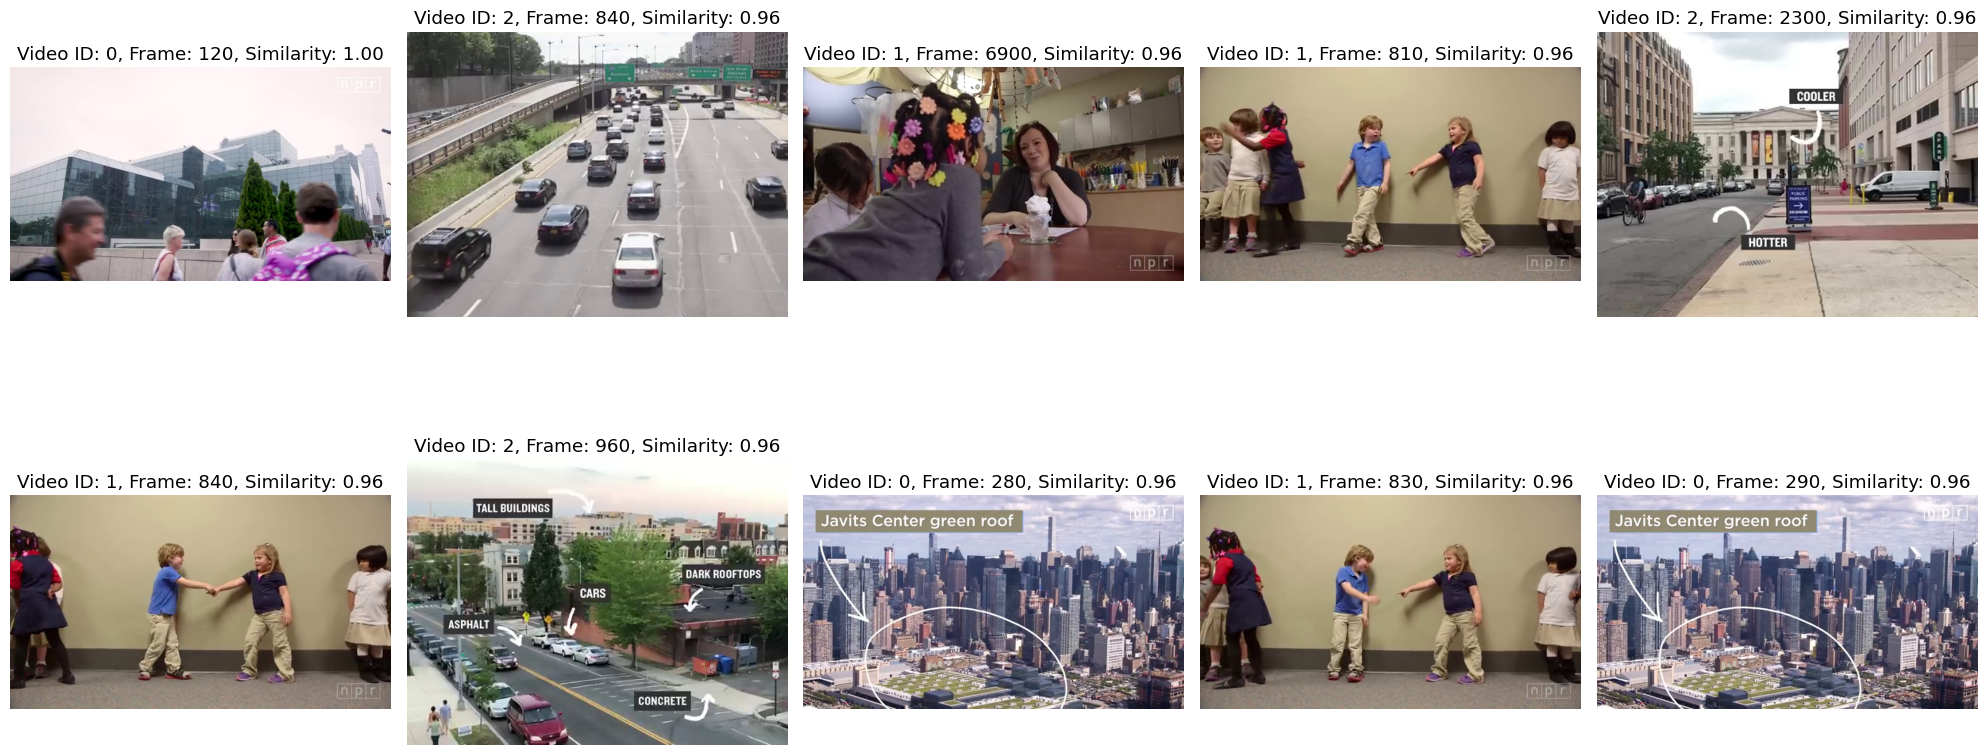

Connection closed.


In [ ]:
import psycopg2
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity

# Function to load a specific frame from a video
def load_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        print(f"Failed to load frame {frame_num} from {video_path}")
        return None

# Connection details
host = "localhost"
database = "mydatabase"
user = "postgres"
password = "postgres"

try:
    # Connect to the database
    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )
    print("Successfully connected to PostgreSQL!")

    # Fetch all vectors from the database
    with conn.cursor() as cur:
        cur.execute("SELECT vidId, frameNum, vector FROM video_embeddings;")
        rows = cur.fetchall()

    # Convert result to DataFrame for better manipulation (optional)
    columns = ['vidId', 'frameNum', 'vector']
    df_embeddings = pd.DataFrame(rows, columns=columns)

    # Select a query vector (example: first row)
    query_vector = df_embeddings.iloc[0]['vector']

    # Convert the string representation of the list to an actual list
    query_vector = ast.literal_eval(query_vector)

    # Convert to numpy array for easier computation
    query_vector = np.array(query_vector).reshape(1, -1)  # Reshape to a row vector

    # Compute cosine similarity for all vectors
    vectors = np.array([ast.literal_eval(v) for v in df_embeddings['vector']])
    similarities = cosine_similarity(query_vector, vectors)

    # Add similarities to DataFrame
    df_embeddings['similarity'] = similarities[0]

    # Sort by similarity and get top 10 similar images
    df_results = df_embeddings.sort_values(by='similarity', ascending=False).head(10)

    # Display the first 10 similar images
    video_paths = [
        "/content/downloads/How Green Roofs Can Help Cities | NPR.mp4",
        "/content/downloads/What Does 'High-Quality' Preschool Look Like? | NPR Ed.mp4",
        "/content/downloads/Why It’s Usually Hotter In A City | Let's Talk | NPR.mp4"
    ]

    plt.figure(figsize=(20, 10))
    for i in range(min(10, len(df_results))):  # Limit to first 10 frames or less if fewer are available
        row = df_results.iloc[i]
        vidId = row['vidId']
        frameNum = row['frameNum']
        video_path = video_paths[vidId]

        print(f"Loading frame {frameNum} from video {video_path}")
        frame = load_frame(video_path, frameNum)

        if frame is not None:
            print(f"Frame {frameNum} from video {video_path} loaded successfully with shape: {frame.shape}")
            plt.subplot(2, 5, i+1)  # Adjust subplot index to match 2x5 grid
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Video ID: {vidId}, Frame: {frameNum}, Similarity: {row['similarity']:.2f}")
            plt.axis('off')
        else:
            print(f"Failed to display frame {frameNum} from video {video_path}")

    plt.tight_layout()
    plt.show()

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

finally:
    if conn is not None:
        conn.close()
        print("Connection closed.")
